# concrete.biopython, practical applications

**concrete.biopython** is a **FHE** library based on python [**biopython**](https://biopython.org/) library. It implements the same objects and functions when they are compatible with fhe.

In bioinformatics, the most basic object is the **sequence**. Sequences generally represent **DNA** and **RNA** strands, or **proteins** which are **amino acids** strands. Bioinformatics computations are most often processings of such sequences. This tutorial presents some basic processing algorithms on sequences, in **FHE**. Indeed, as data is often very sensitive in bioinformatics, using **FHE** guarantees end to end privacy of the data and of its processing.  

Some applications are inspired from this python bioinformatics [tutorial](https://github.com/mrdbourke/coursera_bioinformatics_and_genetic_algorithm_experiment/blob/master/coursera-bioinformatics-content-and-genetic-algorithm-experiment.ipynb). We will first see how to make reusable code to easily generate circuits that can be used for different applications. Then we will see the applications themselves. We will display beforehand the difficulty level of each application.

## Summary
[I. Setting up FHE for practical applications](#section-i)  

[II. Computing the distance between two sequences](#section-ii)  
> [Hamming distance](#section-ii-1)  
  [Levenshtein distance](#section-ii-2)
  
[III. Finding the origin of replication in a sequence](#section-iii)  

[IV. Sorting sequences](#section-iv)  
> [Comparing a list of sequences](#section-iv-1)  
  [Ranking a list of sequences](#section-iv-2)  
  [Sorting sequences of same length](#section-iv-3)  
  
[V. Aligning sequences](#section-v)  

> [Local alignment with the Smith-Waterman algorithm](#section-v-1)  
  [Global alignment with the Needleman-Wunsch algorithm](#section-v-2)  
  [Going further: alignment software used in the industry](#section-v-3)  
  [Bonus: improving the speed of the Levenshtein distance](#section-v-4)  

<a id="section-i"></a>
## I. Setting up FHE for practical applications

Before presenting the algorithms, we will set up some reusable code that will help us for each application later. Given a sequence processing function and a list biopython <span style="color:green">**Seq**</span> objects, our reusable code should allow to:
 
**i.** Generate automatically a circuit adapted to the length of our input and using a given sequence processing function.  

**ii.** Run the circuit and measure performance on given input.

First of all, we need to import **numpy** and **concrete.fhe**, as well as <span style="color:green">**Seq**</span>  from **Bio.Seq**.
Then we import <span style="color:#5CC8FF">**SeqInterface**</span>, <span style="color:orange">**FheSeq**</span>  and **Alphabets** from **concrete_biopython.FheSeq**, and also <span style="color:purple">**BioCircuit**</span> from **concrete_biopython.BioCircuit** which will allow to create circuits easily. 

You can check out the quickstart tutorial presenting these objects in more details.

In [1]:
import numpy as np
from concrete import fhe
from Bio.Seq import Seq, MutableSeq

import sys, os, time
sys.path.append(os.path.dirname(os.getcwd()))

from concrete_biopython.FheSeq import SeqInterface, Alphabets, FheSeq, FheMutableSeq
from concrete_biopython.BioCircuit import BioCircuit

Then, we make a `compute_fhe_output` that creates a circuit for a given sequence processing function, and runs it on a list of <span style="color:green">**Seq**</span> objects:

In [2]:
def compute_fhe_output(seq_list, process_seq, description, seq_output=False, seq_interface=None,  res=False):
    """
    Pack up the creation and running of a circuit,
    and display the result along with the computation times
    `seq_list`: a list of Seq or MutableSeq objects
    `process_seq`: a function taking Seq or FheSeq objects that we want to compile for FHE
    `description`: some description
    `seq_output`: wether the output is a sequence or a regular integer array
    `seq_interface`: a sequence interface for creating FheSeq with correct alphabet
    `res`: wether to output the result or not
    """
    # First print the description and a waiting message
    print(description)
    print("Computing ...", end="", flush=True)
    print("\r", end="")
    
    # prepare configuration
    configuration=fhe.Configuration(
        enable_unsafe_features=True,
        use_insecure_key_cache=True,
        insecure_key_cache_location=".keys",
        dataflow_parallelize=False, # setting it to True may crash the kernel
    )  
    
    # Create a BioCircuit wrapped circuit
    circuit = BioCircuit(
        function=process_seq,
        len_seqs=[len(seq) for seq in seq_list],
        seq_interface=seq_interface or SeqInterface(Alphabets.ASCII), # if None, use a complete Alphabet (slower)
        show_timing=True,
        configuration=configuration,
        seq_output=seq_output
    )

    encrypted = circuit.encrypt(*seq_list)
    fhe_res = circuit.run(encrypted)
    output = circuit.decrypt(fhe_res)        

    print('==> Result :', output, '\n')

    # In case we need the result
    if res:
        return output

That's it ! Before starting our first practical application, we can try out this code on test sequences and processing function, checking homomorphically wether the two first sequences of the list are identical.

In [14]:
# Create a simple sequence processing function and run it in FHE on test sequences:

# check wether two sequences are identical
def process_sequence(seq1, seq2):
    return seq1 == seq2

seq1 = Seq("ACGTACGT")
seq2 = Seq("CGTACGTA")
compute_fhe_output([seq1, seq2], process_sequence, seq_output = False,
                    seq_interface= SeqInterface(Alphabets.DNA_RNA),
                    description='FHE: Are the first two sequences equal ?:')

FHE: Are the first two sequences equal ?:
|  Compiling  : 0.49 s  |
|  Encrypting  : 0.10 s  |
|  Running  : 0.17 s  |
|  Decrypting  : 0.00 s  |
==> Result : 0 



<a id="section-ii"></a>
## II. Computing the distance between two sequences

As a first application, we will compute in FHE the **distance between two sequences**. A distance between two sequences **A** and **B** is a function that measures their similarity and obeys the following conditions:
- If A = B, then *distance(A,B)=0*
- If A ≠ B, then *distance(A,B)>0*
- For all sequences A and B, *distance(A,B) = distance(B,A)*
- For all sequences A,B, and C, *distance(A,C) <= distance(A,B) + distance(B,C)*

Computing the distance between two biological sequences, for instance **DNA** strands, is often used in bioinformatics as a measure of similarity. We will see here the [**hamming distance**](https://en.wikipedia.org/wiki/Hamming_distance) and the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

<a id="section-ii-1"></a>
### Hamming distance 

( difficulty level: *easy* )

The **hamming distance** between two sequences of **same length** is simply the number of positions where the two sequences are different. It is often used in bioinformatics to measure the similarity of biological sequences of same length such as **DNA** strands.  

Let's define the `hamming` function which computes this distance between two arrays. The `hamming_adapter` allows to adapt inputs from either <span style="color:green">**Seq**</span> or <span style="color:orange">**FheSeq**</span> objects:

In [15]:
def hamming(arr1, arr2):
    """
    Return the number of differences between arrays arr1 and arr2
    """
    if arr1.size != arr2.size:
        raise ValueError('arrays must have same size')
        
    return np.sum(arr1 != arr2)

def hamming_adapter(seq1, seq2):
    """
    Adapter for hamming distance of Seq objects
    Convert Seq or FheSeq objects into integer arrays
    """
    if isinstance(seq1, FheSeq) or isinstance(seq1, FheMutableSeq):
        return hamming(seq1.to_array(),seq2.to_array())
    elif isinstance(seq1, Seq) or isinstance(seq1, MutableSeq):
        return hamming(np.array(list(str(seq1))), np.array(list(str(seq2))))
    else:
        return NotImplemented

Let's measure the distance between two short strands of **DNA**, both in python and FHE:

In [16]:
S = Seq("AGGTTGGTAAAATGGTCCGTGGC")
T = Seq("ACCGTAATAAACGTGTCCGTTGG")

# run the circuit in python
OUTPUT_PYTHON = hamming_adapter(S, T)
print('Python: Haming distance of S & T:', OUTPUT_PYTHON)

# run the circuit in FHE and compare the results
compute_fhe_output([S, T], hamming_adapter, seq_output = False,
                   seq_interface= SeqInterface(Alphabets.DNA_RNA),
                   description='FHE: Haming distance of S & T:')

Python: Haming distance of S & T: 10
FHE: Haming distance of S & T:
|  Compiling  : 0.38 s  |
|  Encrypting  : 0.10 s  |
|  Running  : 0.35 s  |
|  Decrypting  : 0.00 s  |
==> Result : 10 



The distance is relatively fast to compute in FHE because it is a simple algorithm.

<a id="section-ii-2"></a>
### Levenshtein distance

( difficulty level: *medium* )

The **Levenshtein distance** between two sequences is a bit more complex to compute. It measures **the number of simple operations** needed to transform a sequence into another one. These three simple operations are the **deletion** of an element, the **addition** of an element, and the **swapping** of two different elements. Check out the pseudo-code algorithm at: [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

This distance is also sometimes used in bioinformatics to measure the similarity of biological sequences with different length.

Again, we define the `levenshtein` function in a recursive fashion (the recursion is in python, but the compiled graph will not be recursive in FHE), as well as a `levenshtein_adapter` to adapt inputs. Note that in `levenshtein` function, we use an **if** condition. While this is forbidden in FHE on encrypted variables, in this case the condition is allowed because it concerns the size of the arrays which is not encrypted.  

However, contrary to the original algorithm where the condition `(arr1[0] == arr2[0])` will stop the computation of the corresponding recursion branch if it is true, the FHE algorithm needs to run both branches of the computation. Indeed, the result of the condition being encrypted, both branches will run which will greatly slow the computation.

In [23]:
def min_array(arr):
    """
    Return the minimum value in an array using boolean mutliplication
    """
    minval = arr[0]
    for i in range(1, arr.size):
        is_lt = arr[i]<minval
        minval = is_lt*arr[i] + (1-is_lt)*minval
    
    return minval

def levenshtein(arr1, arr2):
    """
    Compute the Levenshtein distance between two array objects
    """
    if arr2.size == 0:
        return fhe.one()*arr1.size
    elif arr1.size == 0:
        return fhe.one()*arr2.size
    else:
        iseq0 = (arr1[0] == arr2[0])
        lev1 = levenshtein(arr1[1:], arr2[1:])
        lev2 = levenshtein(arr1[1:], arr2)
        lev3 = levenshtein(arr1, arr2[1:])
        minlev = min_array(fhe.array([lev1, lev2, lev3]))
        return iseq0*lev1 + (1-iseq0)*(1+minlev)

def levenshtein_adapter(seq1, seq2):
    """
    Adapter for levenshtein distance of sequence objects
    Convert Seq or FheSeq objects into integer arrays
    """
    if isinstance(seq1, FheSeq) or isinstance(seq1, FheMutableSeq):
        return levenshtein(seq1.to_array(),seq2.to_array())
    elif isinstance(seq1, Seq) or isinstance(seq1, MutableSeq):
        return levenshtein(np.array(list(str(seq1))), np.array(list(str(seq2))))
    else:
        return NotImplemented
    
S = Seq("ACGT")
T = Seq("CGTA")

OUTPUT_PYTHON = levenshtein_adapter(S, T)
print('Python: Levenshtein distance of S & T:', OUTPUT_PYTHON)

Python: Levenshtein distance of S & T: 2


Let's test this distance on very small DNA strands inputs:

In [18]:
compute_fhe_output([S, T], levenshtein_adapter, seq_output = False,
                   seq_interface= SeqInterface(Alphabets.DNA_RNA),
                   description='FHE: Levenshtein distance of S & T:')

FHE: Levenshtein distance of S & T:
|  Compiling  : 23.12 s  |
|  Encrypting  : 0.07 s  |
|  Running  : 4.73 s  |
|  Decrypting  : 0.00 s  |
==> Result : 2 



The result is very long to compute ! This not due to FHE slowness, but to the algorithm itself which is very greedy. An improved, faster version of the algorithm is proposed in [Bonus: improving the speed of the Levenshtein distance](#section-v-4).

<a id="section-iii"></a>
## III. Finding the origin of replication in a sequence

( difficulty level: *medium* )

As a second application, we will look in FHE for the [**origin of replication**](https://en.wikipedia.org/wiki/Origin_of_replication) in a DNA strand. The **origin of replication** (also called the **replication origin**) is a particular sequence in a genome at which **replication** is initiated, used when a cell divides. This area of the genome sometimes needs to be analyzed, but it needs to be found first.  

In most area of DNA genomes, there is an equal proportion of nucleotides **'A'** (adenine), **'C'** (cytosine), **'G'** (guanine) and **'T'** (thymine). However, around the **origin of replication**, the proportion of guanine and thymine (G and T) **is greater** than the proportion of adenine and cytosine (A et C). This particularity is helpful to find the approximate localisation of the origin of replication.  

In the function `minimum_skew` we take a look at the ratio between letter 'G' to letter 'C', to retrieve the location in the strand where this ratio is minimal. To that extent, we first create a lookup table to map letters 'G' to a 1 and letters 'C' to a -1, the other letters 'A' and 'T' being mapped to 0. Then, we sum up the values throughout the sequences, and keep the first index of the minimum value of this cumulated sum. We also return the whole cumulated sum array for plotting.

We need to use the <span style="color:#5CC8FF">**SeqInterface**</span> class in this case. This class is used internally within the <span style="color:purple">**BioCircuit**</span> class, but we need to explicitly use it here in order to convert letters to integers, and to know the value of the maximum integer that can be encoded, which is linked to the length of the alphabet used:

In [10]:
def minimum_skew(seq):
    """
    Return the index of the minimum skew in a sequence
    Note: Only the first index of minimum skew is returned
    """ 
    # First, create a lookup table to map G to 1 and C to -1
    if isinstance(seq, FheSeq) or isinstance(seq, FheMutableSeq):
        # get the seq_interface of the seq object
        seq_interface = seq.get_seq_interface()        
        CG_integers = seq_interface.to_integers(Seq('CG'))
        letter_table = [0]*(seq_interface.max_integer()+1)
        letter_table[CG_integers[0]]=-1
        letter_table[CG_integers[1]]=1
        letter_table = fhe.LookupTable(letter_table)
        skew_counts = fhe.zeros(len(seq))
    elif isinstance(seq, Seq) or isinstance(seq, MutableSeq):
        letter_table = {'A':0, 'C':-1, 'G':1, 'T':0}
        skew_counts = np.zeros(len(seq)).astype('int')
    else:
        return NotImplemented
    
    # Then compute the cumulated sum and keep the first index of the minimum
    skew_counts[0] = letter_table[seq[0]]
    minimum = skew_counts[0]
    min_index = 0
    for i in range(1,len(seq)):
        # Compute cumulated sum
        skew_counts[i] = skew_counts[i-1] + letter_table[seq[i]]
        # and keep minimum
        ismin = (skew_counts[i]<minimum)
        minimum = min_array(fhe.array([skew_counts[i], minimum]))
        min_index = i*ismin + min_index*(1-ismin)
        
    return min_index, skew_counts


As mentioned, the function will only output the first index where the minimum value is reached. This is a limitation of FHE. It is indeed not possible to retrieve an arbitrary number of locations in FHE, for instance to return a list with all indices where the minimum is reached. We could however return an array of the size of the sequence containing ones where the minimum is reached, or, with very extensive computations, containing the indices of the minimum followed by zeros.  

Another limitation here is the size of the sequence. If the size becomes too long, the values in `skew_counts` may become larger than the maximum capacity of FHE integers that have limited bitwidth. But this could be overcome with counting trick such as splitting the hundreds or thousands in a separate counter variable. 

Let's test our function on a clear sequence, and plot the cumulated sum of 'C' letters minus 'G' letters. Then we test it with encrypted data:

Python: The minimum skew is at index: 18


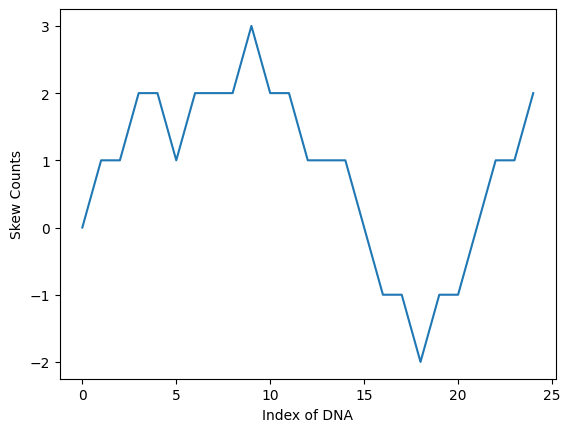

In [11]:
SEQ_O = Seq('AGTGACGTAGCACATCCACGAGGTG')

OUTPUT_PYTHON, skew_counts = minimum_skew(SEQ_O)
print('Python: The minimum skew is at index:', OUTPUT_PYTHON)

# Plot the skew_counts to check them out
import matplotlib.pyplot as plt
plt.plot(skew_counts)
plt.ylabel('Skew Counts')
_=plt.xlabel('Index of DNA')


In [9]:
def process_sequence(seq):
    return minimum_skew(seq)[0] # return only the minimum value for fhe

compute_fhe_output([SEQ_O], process_sequence, seq_output = False,
                   seq_interface= SeqInterface(Alphabets.DNA_RNA),
                   description='FHE: The minimum skew is at index:')

FHE: The minimum skew is at index:
|  Compiling  : 4.39 s  |
|  Encrypting  : 0.71 s  |
|  Running  : 27.24 s  |
|  Decrypting  : 0.00 s  |
==> Result : 18 



<a id="section-iv"></a>
## IV. Sorting sequences

<a id="section-iv-1"></a>
### Comparing two sequences:

As we already saw, <span style="color:green">**Seq**</span> and <span style="color:orange">**FheSeq**</span> classes implement some operators such as **len(**seq**)**, seq**[i:j]**,  or s1**==**s2. They also implement the comparison operators s1 **>** s2, s1 **>=** s2 and their opposite s1 **<** s2, s1 **<=** s2.  

For the <span style="color:green">**Seq**</span> class, a sequence **A** is lower than another sequence **B** (noted *A<B*) if **A** is alphabetically lower than **B** (and not equal to B). The first character is compared first:  
- If *A[0] < B[0]* then *A < B*
- Else, if *A[0] > B[0]* then *A > B*
- Else, *A[0] = B[0]*, so the second character is compared, and so on.  

For instance, `Seq('AB')` is lower than `Seq('AC')`. Also, `Seq('AA')` is lower than the `Seq('AAA')` because the empty character at the end is considered alphabetically lower than all other characters. The <span style="color:orange">**FheSeq**</span> class works with the same principle. Comparing two sequences in alphabetical order is sometimes used inside bigger bioinformatics algorithms. If you need element wise comparison between <span style="color:orange">**FheSeq**</span> objects instead, use `A.to_array() > B.to_array()`.

<a id="section-iv-2"></a>
### Ranking a list of sequences:

( difficulty level: *medium* )

With such comparison operators, we are able to sort a list of sequences. On clear data, it is possible to use `sorted(sequence_list)` to sort a list of sequences, but in FHE, this is impossible for sequences of different lenghts. Indeed, sequences of different length are represented as python objects that are not directly integer arrays, and we cannot set a list of python objects with an encrypted index. For now, let's just compute a rank for each sequence object in the list. 

To do so, we can build a comparison matrix. Suppose our list of sequences is the following : `seqlist = ['CAA', 'AAB', 'CAA', 'AA', 'AAA']`, and we want an ascending ranking. In our comparison matrix, we will compute `comp_matrix[i,j] = seqlist[i]<seqlist[j]` when `i<j`(upper half), and `seqlist[i]>=seqlist[j]` equal to `1-comp_matrix[i,j]` when `j<i` (lower half).  

Then, we can sum up the results on each row to get how many other sequences are lower than the sequence of the row, which gives exactly the ranking of this sequence in the list. Note that even though two identical sequences are provided, they get each a different rank, which is preferable (this is because we used `seqlist[i]>=seqlist[j]` instead of `seqlist[i]>seqlist[j]`).

<div>
<img src="https://rcd-media.com/docs/fhe/tableau_sort.png" width="750"/>
</div>

In [3]:
def rank_sequences(seqlist, ascending=True):
    """
    Returns an array with the rank of each sequence in the list
    """
    n=len(seqlist)
    
    # Create a comparison matrix
    comp_matrix = fhe.zeros((n,n)) # this works in regular python as well
    
    # Fill the matrix with comparison results
    for i in range(0, n):
        for j in range(i+1, n):
            # Compute upper half of the matrix with seqlist[i]<seqlist[j]
            if ascending:
                comp_matrix[i,j] = (seqlist[i]<seqlist[j])
            else:
                comp_matrix[i,j] = (seqlist[i]>=seqlist[j])
                
            # Then fill the contrary to the lower half 
            comp_matrix[j,i] = 1-comp_matrix[i,j]
            
            # Note: 1-comp_matrix[i,j] is the same as seqlist[j]>=seqlist[i] (for ascending)
            # Using seqlist[j]>=seqlist[i] instead of seqlist[j]>seqlist[i]
            # will return a clear order, with different ranks even for
            # equal sequences. Also, this is faster.
            
    # now sum up each row to get a sorting rank for the sequences
    return np.sum(comp_matrix, axis=0)
            
def process_sequences(*seqlist):
    return rank_sequences(seqlist, ascending = True)

Let's test this algorithm on the example sequence list:

In [4]:
# Test the sequence list of the example
SEQ1 = Seq('AA')
SEQ2 = Seq('AAA') # as mentioned earlier, SEQ2 is alphabetically greater than SEQ1
SEQ3 = Seq('AAB')
SEQ4 = Seq('CAA')
SEQ5 = Seq('CAA') # same a SEQ4, will be ranked after it

# Create a shuffled list, like in the example
seqlist = [SEQ5, SEQ3, SEQ4, SEQ1, SEQ2]
# Note: the expected ranks are thus: [5 3 4 1 2], or equally: [4 2 3 0 1]

# Test sorted in python to compare (remember this cannot work in FHE):
print('Sorted list:', sorted(seqlist))

# Test our algorithm in python
OUTPUT_PYTHON = process_sequences(*seqlist)
print("\nThe ranks of sequences are :", OUTPUT_PYTHON)

Sorted list: [Seq('AA'), Seq('AAA'), Seq('AAB'), Seq('CAA'), Seq('CAA')]

The ranks of sequences are : [4 2 3 0 1]


In [14]:
compute_fhe_output(seqlist, process_sequences, seq_output = False,
                   seq_interface = SeqInterface("ABCD"),
                   description='FHE: The ranks of sequences are:')

FHE: The ranks of sequences are:
|  Compiling  : 1.63 s  |
|  Encrypting  : 0.07 s  |
|  Running  : 0.35 s  |
|  Decrypting  : 0.00 s  |
==> Result : [4 2 3 1 0] 



<a id="section-iv-3"></a>
### Sorting sequences of same length:

( difficulty level: *hard* )

We saw that in FHE, it is impossible to sort a list for sequences of different lengths. But for sequences of identical lengths (or with adjusted length as we will see), there is a very computationally intensive way of proceeding.  

When given a list `[a,b]` of two encrypted numbers **a** and **b**, we can sort them using the formula `sortedlist  = [ a*(a<b) + b*(b<a), a*(a>b) + b*(b>a) ]`. This formula uses what we can call a *boolean sum*. For two numbers, this is already computationally intensive, but it works. For a bigger list of numbers `numlist`, the same applies. Let's see how this can be done, using python for now:


In [15]:
# Sorting a list of numbers
numlist = [8,10,6,4,0,2]
rank = rank_sequences(numlist) # the algorithm also works for any list of camparable objects
n=len(numlist)

# To sort the numbers, we simple make a boolean sum of them all that only keeps the one with the correct rank
sortedlist = [ np.sum([numlist[k]*(i==rank[k]) for k in range(n)]) for i in range(n) ]
print('sorted :',sortedlist)

sorted : [0, 2, 4, 6, 8, 10]


For a lists of elements of length `n`, we need to compute `n*n` steps of `numlist[k]*(i==rank[k])` in addition to the ranking algorithm. But recall we want to sort sequences. We can do the same for sequences by also looping on the index `j` in each sequence. When sequences have different lengths, we will first equalize their lengths by appending empty characters at the end of the shortest ones with `adjust_lenghts`.

In [5]:
def adjust_lenghts(seqlist):
    """
    Append empty characters to short sequences
    so they all have the same length
    """
    lengths = [ len(s) for s in seqlist ]
    maxlen = np.max(lengths)
    newlist = []
    for s in seqlist:
        if len(s) < maxlen:
            if isinstance(s, FheSeq) or isinstance(s, FheMutableSeq):
                s += FheSeq(fhe.zeros(maxlen-len(s)), s.get_seq_interface())
            elif isinstance(s, Seq) or isinstance(s, MutableSeq):
                s += Seq('\0'*(maxlen-len(s)))
            else:
                return NotImplemented
        newlist.append(s)
    
    return newlist

def sort_sequences(seqlist, ascending=True):
    """
    Sort sequences
    """
    # Rank the sequences
    rank = rank_sequences(seqlist, ascending)
    
    # Adjust their length to be equal if needed
    seqlist = adjust_lenghts(seqlist)
    
    # Create a new list to hold the result
    n=len(seqlist)
    m=len(seqlist[0])
    sorted_list = []
    
    if isinstance(seqlist[0], FheSeq) or isinstance(seqlist[0], FheMutableSeq):
        lib = fhe
        seq_interface = seqlist[0].get_seq_interface()
    else:
        lib = np
    
    # Fill the array with a boolean sum of all sequences at each row
    for i in range(n): # i is the index of the sequence in the sorted list
        i_eq_rank_k = rank==i
        sorted_array = lib.zeros(m) if lib is fhe else ''
        for j in range(m): # j is the index of the letter in the sequence
            if lib is fhe:
                # k is the index of a sequence in the unsorted list
                # we could also put seqlist inside a 2d array and use a dot product here
                sorted_array[j] = np.sum( [seqlist[k][j]*i_eq_rank_k[k] for k in range(n)] )
            else:
                for k in range(n):
                    sorted_array += seqlist[k][j]*int(i_eq_rank_k[k])
        
        # Create sequence object from this array
        if lib is fhe:
            sorted_list.append(seq_interface.FheSeq_from(sorted_array))
        else:
            sorted_list.append(Seq(sorted_array))

    # Return the list of sorted (adjusted) sequences
    return sorted_list


Now, we want to make again a `process_sequence` that will work both in python and FHE. Because `sort_sequences` returns a list of sequences, we will need to concatenate them again in FHE and return an array so it can be decrypted.

In [6]:
# Test the same sequence list
SEQ1 = Seq('AA')
SEQ2 = Seq('AAA')
SEQ3 = Seq('AAB')
SEQ4 = Seq('CAA')
SEQ5 = Seq('CAA')

seqlist = [SEQ5, SEQ3, SEQ4, SEQ1, SEQ2]

# Concatenate sequences using the + operator
def concat_sequences(seqlist):
    concat_seq = seqlist[0]   
    for seq in seqlist[1:]:
        concat_seq = concat_seq + seq
    return concat_seq

def process_sequences(*seqlist):
    sorted_list = sort_sequences(seqlist)
    if isinstance(seqlist[0], FheSeq) or isinstance(seqlist[0], FheMutableSeq):
        return concat_sequences(sorted_list).to_array()
    elif isinstance(seqlist[0], Seq) or isinstance(seqlist[0], MutableSeq):
        return sorted_list
    else:
        return NotImplemented

OUTPUT_PYTHON = process_sequences(*seqlist)
print('The sorted list of sequences is:\n', OUTPUT_PYTHON)

The sorted list of sequences is:
 [Seq('AA '), Seq('AAA'), Seq('AAB'), Seq('CAA'), Seq('CAA')]


In [22]:
def slice_sequence_n(seq, n):
    """
    Slice a sequence into n subsequences of equal size
    """
    seqs=[]
    index=0
    length = len(seq)//n
    while index < len(seq):
        seqs.append(seq[index:index+length])
        index+=length
    return seqs

seq_interface = SeqInterface("ABCD")

# test again on a limited alphabet to be faster
sorted_seq = compute_fhe_output(seqlist, process_sequences, seq_output = False,
             seq_interface = seq_interface,
             description='The sorted sequences as array is:', res=True)

OUTPUT_FHE = [seq_interface.array_to_Seq(s) for s in slice_sequence_n(sorted_seq, len(seqlist))]
print('The sorted list of sequences is:\n', OUTPUT_FHE)

The sorted sequences as array is:
|  Compiling  : 3.84 s  |
|  Encrypting  : 1.09 s  |
|  Running  : 3.12 s  |
|  Decrypting  : 0.00 s  |
==> Result : [0 0 0 0 0 0 0 0 1 2 0 0 2 0 0] 

The sorted list of sequences is:
 [Seq('AAA'), Seq('AAA'), Seq('AAB'), Seq('CAA'), Seq('CAA')]


KeySetCache: miss, regenerating .keys/14202293608837441708/0_0


<a id="section-v"></a>
## V. Aligning sequences

Sequence alignment algorithms are extensively employed in the field of bioinformatics in order to identify patterns of similarity between sequences. These algorithms come in two main types: local and global alignment. Local alignment algorithms are designed to discover optimal local matches between two sequences, such as pinpointing specific a common segment within longer gene sequences. Conversely, global alignment algorithms strive to find the best alignment across the entire length of sequences, making them suitable for comparing different versions of the same gene, for example.

<a id="section-v-1"></a>
### Local alignment with the Smith-Waterman algorithm

( difficulty level: hard )

The [Smith-Waterman](https://en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm) algorithm is a local alignment algorithm. Given two sequences, it will look for two segments in each sequence that have a minimal cost for transforming one into the other, and it will output how to transform one segment into the other and vice-versa. The transformation of a segment into another is made with the following possible steps:
- no transformation, the characters are matching
- swapping the characters, they are non matching
- skipping a character in one segment only, this is called a gap

Each possible step is attributed a scoring, for instance:
```python
class Score:
    MATCH = 1
    MISMATCH = -1
    GAP = -1
```

To transform the segment `'CAG'` into the segment `'ACGA'` for example, we can skip `C` in the first segment (gap), match the two `A`s (match), skip the `C` in the second segment (gap), match the `G`s and finally skip the `A` in the second segment (gap). This gives a total score of `-1` (three gaps and two matches, no mismatches). The transformation, called an alignment, is written like this (the `-` character being used for gaps):
```
CA-G-
-ACGA
``` 

The idea of the **Smith-Waterman** algorithm is the following (see figure):
1. Compute a grid (the **score  matrix**), from top-left to bottom-right cell, containing all the possible local alignment scores between each pair of characters, and keep track of the total maximum score in the grid and its location. At the same time, keep a trace in another grid (the **trace matrix**) of the direction to take in order to reach the next best score between the previously computed grid cells of the score matrix in the **LEFT**, **UP**, and **DIAGONAL** directions (**LEFT = 1**, **UP = 2** and **DIAGONAL = 3**). An additional first row and column are filled with zeros in the score matrix. If the path arrives there in the trace matrix, it will stop.
2. Start at the location of the **total maximum score** of the score matrix, in the trace matrix, and follow the backward path indicated by the direction values in the trace matrix. This will draw a path of a local alignment between two segments of the sequences that maximise the alignment score. The alignment sequences are computed backwards. As the algorithm is local, this path may be very short, starting from the maximum score value and stopping whenever the score gets to a stop value **STOP = 0**. More precisions about the mathematical foundations [here](https://en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm#).

<div style="margin-top: 40px; margin-bottom: 20px;">
<img src="https://rcd-media.com/docs/fhe/mat_1.jpg" width="600"/>
</div>
<div style="text-align: center;  margin-left: 50px; margin-top: 20px; margin-bottom: 45px;">
  <h3>Smith Waterman matrices for sequences 'ATACAGT' and 'GGATGAC'</h3>
</div>

Let's implement the algorithm in a pure python and FHE compatible way, and test it on the same example as in the figure:

In [10]:
def max_list(l, strictly_gt=True):
    """
    Return the maximum value in a list using boolean mutliplication,
    along with the argmax (the index of the maximum)
    
    strictly_gt: set to True, it will return the index of the first maximum found in case there are
    several identical values, while set to False, it will return the index of the last maximum
    """
    maxval = l[0]
    argmax = 0
    for i in range(1, len(l)):
        is_gt = l[i]>maxval if strictly_gt else l[i]>=maxval
        maxval = is_gt*l[i] + (1-is_gt)*maxval
        argmax = is_gt*i + (1-is_gt)*argmax
    
    return maxval, argmax

# Assigning the constants for the scores
# These can be changed depending on what alignment we are looking for
class Score:
    MATCH = 1
    MISMATCH = -1
    GAP = -1

# Assigning the constant values for the traceback
class Trace:
    STOP=0
    LEFT=1
    UP=2
    DIAG=3

def smith_waterman(seq1, seq2, strictly_gt=True):
    """
    Returns the Smith Waterman local alignment of two sequences
    
    strictly_gt=True will favor shorter, more exact sequences
    while strictly_gt=False will favor longer, less exact sequences
    """   
    ## 1
    # Generating the empty matrices for storing scores and tracing
    row = len(seq1) + 1
    col = len(seq2) + 1
    score_matrix = fhe.zeros((row, col))
    tracing_matrix = fhe.zeros((row, col))
    
    # set variables depending on python or FHE run:
    if isinstance(seq1, FheSeq) or isinstance(seq1, FheMutableSeq):
        seq_interface = seq1.get_seq_interface()
        zero_val = fhe.zero()
        empty_char =  seq_interface.letter_to_integer('\0')
        gap_char = seq_interface.letter_to_integer('-')
        make_empty_seq = lambda x: FheMutableSeq(fhe.zeros(x), seq_interface) # we need mutable sequences 
    elif isinstance(seq1, Seq) or isinstance(seq1, MutableSeq):
        zero_val = 0
        empty_char = '\0'
        gap_char = '-'
        make_empty_seq = lambda x: MutableSeq('\0'*x)        
    else:
        return NotImplemented
        
    # Initializing the variables to find the highest scoring cell
    max_score = max_i = max_j = -1
    
    # Calculating the scores for all cells in the score matrix
    for i in range(1, row):
        for j in range(1, col):
            # Calculating the diagonal score (match score)
            is_eq = seq1[i - 1] == seq2[j - 1]
            match_value = Score.MATCH * is_eq + Score.MISMATCH* (1-is_eq)
            diagonal_score = score_matrix[i - 1, j - 1] + match_value
            
            # Calculating the vertical gap score
            vertical_score = score_matrix[i - 1, j] + Score.GAP
            
            # Calculating the horizontal gap score
            horizontal_score = score_matrix[i, j - 1] + Score.GAP
            
            # Taking the local highest score and where it comes from
            value_list = [zero_val, horizontal_score, vertical_score, diagonal_score]
            score_matrix[i, j], tracing_matrix[i, j] = max_list(value_list, strictly_gt)
            # if some scores are identical and are the maximum value, the value tracing_matrix[i,j] will
            # depend on the parameter strictly_gt (see max_list function)

            # now, tracing_matrix[i, j] = 0, 1, 2 or 3, meaning STOP, LEFT, UP or DIAG
                
            # Tracking the cell with the global maximum score
            is_ge = score_matrix[i, j] >= max_score
            not_is_ge = (1-is_ge)
            max_i = max_i * not_is_ge + i * is_ge
            max_j = max_j * not_is_ge + j * is_ge
            max_score = max_score * not_is_ge + score_matrix[i, j] * is_ge       
    
    if isinstance(seq1, Seq) or isinstance(seq1, MutableSeq):
        print('Smith Waterman local alignment')
        print('\nScore matrix :')
        print(score_matrix)
        print('\nTracing matrix :')
        print(tracing_matrix)
        
    ## 2
    # Initializing the variables for tracing
    len_out = max(row,col)-1
    aligned_seq1 = make_empty_seq(len_out)
    aligned_seq2 = make_empty_seq(len_out)
    ind_ij = fhe.zeros((row, col))
    
    # Tracing and computing the pathway with the local alignment from the global maximum
    #  while tracing_matrix[max_i, max_j] != Trace.STOP:
    for k in reversed(range(len_out)):

        # select value in tracing_matrix at encrypted indices max_i, max_j:
        ind_i = np.arange(row)==max_i
        ind_j = np.arange(col)==max_j
        
        for i in range(0, row):
            for j in range(0, col):
                ind_ij[i,j] = ind_i[i] & ind_j[j] # using & for binary is faster than *
        
        V = np.sum(tracing_matrix*ind_ij)

        VSTOP = (V==Trace.STOP)*1
        VLEFT = (V==Trace.LEFT)*1
        VUP = (V==Trace.UP)*1
        VDIAG = (V==Trace.DIAG)*1
        VLEFT_or_VDIAG = VLEFT + VDIAG
        VUP_or_VDIAG = VUP + VDIAG        
        # Note: the *1 is just for pure python, to convert booleans into ints
        
        # select value in seq1 at encrypted index max_i - 1:
        v1 = seq1[max_i-1]
        # Note: we accessed seq1 with an encrypted index max_i-1, this is allowed by the FheSeq class
        # but it is computationally expensive, see FheSeq.__getitem__ function 
                
        current_aligned_char1 = (VUP_or_VDIAG)*v1 + VLEFT*gap_char + VSTOP*empty_char;
        # Note: in FHE, one should make as few multiplications as possible for speed purpose,
        # that's why we regrouped VDIAG + VUP here instead of VDIAG*v1 + VUP*v1
        
        # select value in seq2 at encrypted index max_j - 1:
        v2 = seq2[max_j-1]
        current_aligned_char2 = (VLEFT_or_VDIAG)*v2 + VUP*gap_char + VSTOP*empty_char; 
        
        max_i = max_i - (VUP_or_VDIAG)
        max_j = max_j - (VLEFT_or_VDIAG)
        
        aligned_seq1[k] = current_aligned_char1
        aligned_seq2[k] = current_aligned_char2

    return aligned_seq1, aligned_seq2


In pure python, a stop condition can be verified and lead to the effective end of the algorithm, producing alignment sequences of variable sizes. However, as you can see, in FHE a condition cannot lead to the end of the algorithm. Thus, instead of stopping the path, a stop value will make the path stagnate, and it will append empty characters to the aligned sequences. This will lead to fixed-size sequences with apparent variable sizes when printed.

Also note that it is possible to access FheSeq values at encrypted index (see `v1 = seq1[max_i-1]`). It uses a trick, the same we used to select the value in the trace matrix at encrypted indices `max_i, max_j`. This trick is very slow to process compared to unencrypted indexing. That's why the complexity of this algorithm is normally in **O(mn)**, but in FHE, because of the loops for the trick, it is actually in **O(p^3)** where `p=max(m,n)`.

Let's first test the algorithm in pure python, on the same sequences as in the previous figure. The printed matrices should be identical:

In [13]:
SEQ1 = Seq('ATACAGT')
SEQ2 = Seq('GGATGAC')

seqlist = [SEQ1, SEQ2]

def process_sequence(*seqlist):
    if isinstance(seqlist[0], FheSeq) or isinstance(seqlist[0], FheMutableSeq):
        aligned_seq1, aligned_seq2 = smith_waterman(seqlist[0],seqlist[1])
        newseq = concat_sequences([aligned_seq1, aligned_seq2])
        return newseq.to_array()
    elif isinstance(seqlist[0], Seq) or isinstance(seqlist[0], MutableSeq):
        aligned_seq1, aligned_seq2 = smith_waterman(seqlist[0], seqlist[1])
        return [Seq(aligned_seq1), Seq(aligned_seq2)]
    else:
        return NotImplemented
    
OUTPUT_PYTHON = process_sequence(*seqlist)
print('\nThe aligned sequences are:\n', OUTPUT_PYTHON[0], '\n', OUTPUT_PYTHON[1])

Smith Waterman local alignment

Score matrix :
[[0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 0 2 1 0 0]
 [0 0 0 1 1 1 2 1]
 [0 0 0 0 0 0 1 3]
 [0 0 0 1 0 0 1 2]
 [0 1 1 0 0 1 0 1]
 [0 0 0 0 1 0 0 0]]

Tracing matrix :
[[0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 3 0]
 [0 0 0 0 3 1 0 0]
 [0 0 0 3 2 3 3 1]
 [0 0 0 0 0 0 2 3]
 [0 0 0 3 0 0 3 2]
 [0 3 3 0 0 3 0 2]
 [0 0 0 0 3 0 0 0]]

The aligned sequences are:
   AT-AC 
   ATGAC


Remember, the actual output aligned sequences have a fixed length, but they may start with the empty character `'\0'` repeated several times, which does not show when printed.  

We can now test it in FHE, starting with shorter sequences for a faster computation (remember the very high algorithmic complexity of the algorithm): 

In [12]:
# we can set shorter sequences for faster computation, because the algorithm is very greedy
SEQ1 = Seq('ATG')
SEQ2 = Seq('GAT')

#SEQ1 = Seq('ATACAGT')
#SEQ2 = Seq('GGATGAC')

seqlist = [SEQ1, SEQ2]
seq_interface = SeqInterface('ACGTU-') # we need the - character as well here
aligned_seqs = compute_fhe_output(seqlist, process_sequence, seq_output = False,
                                seq_interface = seq_interface,
                                description='FHE Smith-Waterman',res=True)
len_out = len(aligned_seqs)//2

aligned_seq1 = seq_interface.array_to_Seq(aligned_seqs[0:len_out])
aligned_seq2 = seq_interface.array_to_Seq(aligned_seqs[len_out:])
print('The aligned sequences are:\n', aligned_seq1, '\n', aligned_seq2)

FHE Smith-Waterman
|  Compiling  : 7.33 s  |
|  Encrypting  : 0.17 s  |
|  Running  : 7.47 s  |
|  Decrypting  : 0.00 s  |
==> Result : [0 2 5 0 2 5] 

The aligned sequences are:
  AT 
  AT


#### Going further
One can also try different combinations of matching, substitution and gap penalties/scores.

For instance, another scoring system that penalizes more gaps might be:

```python
class Score:
    MATCH = 1
    MISMATCH = -1
    GAP = -2
```

And another penalizing more mismatches:

```python
class Score:
    MATCH = 1
    MISMATCH = -2
    GAP = -1
```

More complicated scoring systems may attribute values not only for the type of transformation, but also for the characters that are involved. For example, a match between `A` and `A` may be given a score of `1`, but a match between `T` and `T` may be given score `4`. The same applies for mismatches and gaps.

<a id="section-v-2"></a>
### Global alignment with the Needleman-Wunsch algorithm

( difficulty level: hard )

The [Needleman-Wunsch](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm) algorithm is a global and optimal alignment algorithm. It is almost identical to the **Smith-Waterman** algorithm. Instead of going from the maximum score cell to a stop value, which leads to short and local alignment sequences, it runs from the bottoms-left cell of the trace matrix up to its top-left cell, leading to long and global alignment sequences. The output of the algorithm are optimal transformations of one whole sequence into the other and vice-versa.

Being optimal means that the results are not approximations or best guesses, and that's why the algorithm is widely used for global alignment, but it is also expensive to run for long sequences.

<div style="margin-top: 30px;">
</div>

The two steps for this algorithm are the following:
1. The first step is almost identical to the one from **Smith-Waterman**. The first difference is the scoring which allows negative values. Then, the trace matrix has only one stop value on the top-left cell. Finally, at initialization, the first row and column of the two matrices are non zero and set so as to lead the path toward the top-left cell rather than stopping.
2. Regarding the second step, let's rewrite and highlight its differences with the one from **Smith-Waterman** that we saw in the previous section: Start at the **bottom-right cell**, in the trace matrix, and follow the backward path indicated by the direction values in the trace matrix. This will draw a path of a **global** alignment between the whole sequences that maximise the alignment score. The alignment sequences are computed backwards. As the algorithm is **global**, this path may be quite long, starting from bottom-right and stopping at top-left. Its length of non empty characters can be between `max(len1, len2)` if the path is fully diagonal, and `len(1) + len(2)` if the path has the shape of a stair. 


<div style="margin-top: 40px; margin-bottom: 20px;">
<img src="https://rcd-media.com/docs/fhe/mat_2.jpg" width="600"/>
</div>
<div style="text-align: center;  margin-left: 50px; margin-top: 20px; margin-bottom: 45px;">
  <h3>Needleman Wunsch matrices for sequences 'ATACAGT' and 'GGATGAC'</h3>
</div>

Let's implement this new algorithm also in a pure python and FHE compatible way, and test it on the same example as previously. We mark the differences with the previous algorithm in the code with `### DIFF` to make them easy to see:

In [18]:
# Assigning the constants for the scores
# These can be changed depending on what alignment we are looking for
class Score:
    MATCH = 1
    MISMATCH = -1
    GAP = -1

# Assigning the constant values for the traceback
class Trace:
    STOP = 0 # STOP is only needed for the FHE version of the algorithm which cannot use a while loop
    LEFT = 1 
    UP = 2
    DIAG = 3

def needleman_wunsch(seq1, seq2):
    """
    Returns the Needleman Wunsch global alignment of two sequences
    """  
    ## 1
    # Generating the empty matrices for storing scores and tracing
    row = len(seq1) + 1
    col = len(seq2) + 1
    score_matrix = fhe.zeros((row, col))
    tracing_matrix = fhe.zeros((row, col))
    
    # initialize the first row and col of the matrix
    ### DIFF (as the algorithm is global, if it reaches the first row or column
    #   in the traceback process, it won't stop but rather continue straight to top-left)
    score_matrix[:,0] = -1*np.arange(row)
    tracing_matrix[1:,0] = 2 # go up if first left column is reached
    score_matrix[0,:] = -1*np.arange(col)
    tracing_matrix[0,1:] = 1 # go left if first row is reached    
    
    # set variables depending on python or FHE run:
    if isinstance(seq1, FheSeq) or isinstance(seq1, FheMutableSeq):
        #   sequence is as long as the longest of the two input sequences)
        seq_interface = seq1.get_seq_interface()
        empty_char = seq_interface.letter_to_integer('\0')
        gap_char = seq_interface.letter_to_integer('-')
        make_empty_seq = lambda x: FheMutableSeq(fhe.zeros(x), seq_interface)
    elif isinstance(seq1, Seq) or isinstance(seq1, MutableSeq):
        empty_char = '\0'
        gap_char = '-'
        make_empty_seq = lambda x: MutableSeq('\0'*x)
    else:
        return NotImplemented
        
    # Initializing the variables to find the highest scoring cell
    max_score = max_i = max_j = -1
    
    # Calculating the scores for all cells in the matrix
    for i in range(1, row):
        for j in range(1, col):
            # Calculating the diagonal score (match score)
            is_eq = seq1[i - 1] == seq2[j - 1]
            match_value = Score.MATCH * is_eq + Score.MISMATCH* (1-is_eq)
            diagonal_score = score_matrix[i - 1, j - 1] + match_value
            
            # Calculating the vertical gap score
            vertical_score = score_matrix[i - 1, j] + Score.GAP
            
            # Calculating the horizontal gap score
            horizontal_score = score_matrix[i, j - 1] + Score.GAP
            
            # Taking the local highest score and where it comes from
            values = fhe.array([horizontal_score, vertical_score, diagonal_score])
            ### DIFF (the value list has only 3 elements here, without a stopping option)
            score_matrix[i, j], tracing_matrix[i, j] = max_list(values, strictly_gt=True)
            ### DIFF (strictly_gt=False ensures the diagonal direction will be favored
            #   in case the score is the same as vertical or horizontal, see max_list function)    
            tracing_matrix[i, j] += 1 # the argmax of the list is 0,1,2 and we want 1,2,3
            
            # now, tracing_matrix[i, j] = 0, 1, 2 or 3, meaning STOP, LEFT, UP or DIAG
                
            ### DIFF (No tracking of the cell with the global maximum score here)
 
    if isinstance(seq1, Seq) or isinstance(seq1, MutableSeq):
        print('Needleman-Wunsch global alignment')
        print('\nScore matrix :')
        print(score_matrix)
        print('\ntracing matrix :')
        print(tracing_matrix)
    
    ## 2
    # Initializing the variables for tracing
    ### DIFF (the maximum possible length is the sum of the lengths when the path has a stair shape)
    len_out = len(seq1)+len(seq2)
    aligned_seq1 = make_empty_seq(len_out)
    aligned_seq2 = make_empty_seq(len_out)
    ind_ij = fhe.zeros((row, col))
    
    # Tracing and computing the pathway with the local alignment from the bottom-left up
    ### DIFF (the traceback process starts at the bottom-right corner of the matrix)    
    max_i = row-1
    max_j = col-1
    
    # select the starting value in tracing_matrix at index max_i, max_j (unencrypted for now)
    V = tracing_matrix[max_i, max_j]
        
    for k in reversed(range(len_out)):
  
        VSTOP = (V==Trace.STOP)*1 # this will happen only when max_i = max_j = 0        
        VLEFT = (V==Trace.LEFT)*1
        VUP = (V==Trace.UP)*1
        VDIAG = (V==Trace.DIAG)*1
        VLEFT_or_VDIAG = VLEFT + VDIAG
        VUP_or_VDIAG = VUP + VDIAG
        # Note: the *1 is just for pure python, to convert booleans into ints
                        
        # select value in seq1 at encrypted index max_i - 1:
        v1 = seq1[max_i-1]
        # Note: we accessed seq1 with an encrypted index max_i-1, this is allowed by the FheSeq class
        # but it is computationally expensive, see FheSeq.__getitem__ function                 
        current_aligned_char1 = (VUP_or_VDIAG)*v1 + VLEFT*gap_char + VSTOP*empty_char;
        # Note: in FHE, one should make as few multiplications as possible for speed purpose,
        # that's why we regrouped (VDIAG + VUP)*v1 here, instead of VDIAG*v1 + VUP*v1
        
        # select value in seq2 at encrypted index max_j - 1:
        v2 = seq2[max_j-1]
        current_aligned_char2 = (VLEFT_or_VDIAG)*v2 + VUP*gap_char + VSTOP*empty_char; 
        
        max_i = max_i - (VUP_or_VDIAG)
        max_j = max_j - (VLEFT_or_VDIAG)
        
        aligned_seq1[k] = current_aligned_char1
        aligned_seq2[k] = current_aligned_char2
        
        # select value in tracing_matrix at encrypted indices max_i, max_j:
        ind_i = (np.arange(row)==max_i)*1
        ind_j = (np.arange(col)==max_j)*1
        
        if k == 0: # no need to compute the last one
            break
            
        ### DIFF (as the first indices where unencrypted, we prevented 1 costly computation)
        for i in range(0, row):
            for j in range(0, col):
                ind_ij[i,j] = ind_i[i] & ind_j[j]
        
        V = np.sum(tracing_matrix*ind_ij)  
        
    return aligned_seq1, aligned_seq2

Let's now also first test the algorithm in pure python, on the same sequences as in the previous figure. The printed matrices should be identical to the figure of this section. We will also compute a `similarity_score` before and after alignment, to verify that the algorithm actually increases characters alignment:

In [21]:
def similarity_score(seq1, seq2):
    """
    Compute the number of identical characters in two aligned sequences
    """
    nequal = 0
    for i in range(min(len(seq1), len(seq2))):
        nequal += 1 if seq1[i]==seq2[i] and seq1[i]!='-' and seq1[i]!='\0' else 0
    return nequal

SEQ1 = Seq('ATACAGT')
SEQ2 = Seq('GGATGAC')

seqlist = [SEQ1, SEQ2]

def process_sequence(*seqlist):
    if isinstance(seqlist[0], FheSeq) or isinstance(seqlist[0], FheMutableSeq):
        aligned_seq1, aligned_seq2 = needleman_wunsch(seqlist[0],seqlist[1])
        newseq = concat_sequences([aligned_seq1, aligned_seq2])
        return newseq.to_array()
    elif isinstance(seqlist[0], Seq) or isinstance(seq_liseqlistst[0], MutableSeq):
        aligned_seq1, aligned_seq2 = needleman_wunsch(seqlist[0], seqlist[1])
        return [Seq(aligned_seq1), Seq(aligned_seq2)]
    else:
        return NotImplemented
    
OUTPUT_PYTHON = process_sequence(*seqlist)
print('\nThe aligned sequences are:\n', OUTPUT_PYTHON[0], '\n', OUTPUT_PYTHON[1])
print('\nSimilarity score before alignment :', similarity_score(SEQ1, SEQ2) )
print('Similarity score after alignment :', similarity_score(*OUTPUT_PYTHON))

Needleman-Wunsch global alignment

Score matrix :
[[ 0 -1 -2 -3 -4 -5 -6 -7]
 [-1 -1 -2 -1 -2 -3 -4 -5]
 [-2 -2 -2 -2  0 -1 -2 -3]
 [-3 -3 -3 -1 -1 -1  0 -1]
 [-4 -4 -4 -2 -2 -2 -1  1]
 [-5 -5 -5 -3 -3 -3 -1  0]
 [-6 -4 -4 -4 -4 -2 -2 -1]
 [-7 -5 -5 -5 -3 -3 -3 -2]]

tracing matrix :
[[0 1 1 1 1 1 1 1]
 [2 3 1 3 1 1 1 1]
 [2 2 3 2 3 1 1 1]
 [2 2 2 3 2 3 3 1]
 [2 2 2 2 2 2 2 3]
 [2 2 2 2 2 2 3 2]
 [2 3 3 2 2 3 2 2]
 [2 2 2 2 3 2 2 2]]

The aligned sequences are:
     --AT-ACAGT 
     GGATGAC---

Similarity score before alignment : 1
Similarity score after alignment : 4


Remember again, the actual output aligned sequences have also a fixed length here, but they may start with the empty character `'\0'` repeated several times, which does not show when printed.  

We can now test it again in FHE, starting as well with shorter sequences for a faster computation:

In [20]:
# we can set shorter sequences for faster computation, because the algorithm is very greedy
SEQ1 = Seq('ATG')
SEQ2 = Seq('GAT')

#SEQ1 = Seq('ATTACAG')
#SEQ2 = Seq('GGATGAC')

seq_list = [SEQ1, SEQ2]

seq_interface = SeqInterface('ACGT-')
aligned_seqs = compute_fhe_output(seq_list, process_sequence, seq_output = False,
                                  seq_interface=seq_interface,
                                  description='Needleman-Wunsch :',res=True)
len_out = len(aligned_seqs)//2

aligned_seq1 = seq_interface.array_to_Seq(aligned_seqs[0:len_out])
aligned_seq2 = seq_interface.array_to_Seq(aligned_seqs[len_out:])

print('\nThe aligned sequences are:\n', aligned_seq1,'\n', aligned_seq2)
print('\nSimilarity score before alignment :', similarity_score(SEQ1, SEQ2) )
print('Similarity score after alignment :', similarity_score(aligned_seq1, aligned_seq2))


Needleman-Wunsch :
|  Compiling  : 13.71 s  |
|  Encrypting  : 0.28 s  |
|  Running  : 6.61 s  |
|  Decrypting  : 0.00 s  |
==> Result : [0 0 1 2 5 4 0 0 4 2 5 1] 


The aligned sequences are:
   -ATG 
   GAT-

Similarity score before alignment : 0
Similarity score after alignment : 2


Finally, one can also try different combinations of matching, substitution and gap penalties/scores to get different behaviors of the algorithm.

<a id="section-v-3"></a>
### Going further: alignment software used in the industry

The two algorithm we saw have both positive and negative aspects:
- The **Needleman-Wunsch** algorithm is quite greedy, particularly in **FHE**, so it takes time to compute global alignment on long sequences. However, it is optimal and generally used on relatively short sequences.
- The **Smith-Waterman** algorithm is as greedy as the **Needleman-Wunsch**, and will only output a single aligned sequence. It is a major problem in bioinformatics where we usually want to retrieve as much local alignments as possible within a given score threshold. Also, while the first sequence (the **query** sequence) is generally quite small, we want to look for it into a potentially very long sequence (the **reference**).

Numeral [alignment softwares](https://en.wikipedia.org/wiki/List_of_sequence_alignment_software#Short-read_sequence_alignment) have been designed to serve diverse objectives. Some of the most famous and widely used are **BLAST** (Basic Local Alignment Search Too) and **BWA** (Burrows–Wheeler aligner), which are **local alignment** algorithm and both come with many variations. They enable rapid searching for a query sequence within a considerably long reference sequence, sometimes even encompassing entire databases of sequences. They retrieve several alignement sequences which scores are over a given threshold.

Their main principle is similar: first run once a heavy computation so as to prepare the **reference** sequence for optimal search, then look quickly for any **queries**, with or without exact match, and using statistical heuristics. The preparation step takes a lot of time, but then, it allows to run as many quick queries as needed. The human genome is for instance a common reference that researchers use to look for gene variants queries.

In **2023**, none of these complexe algorithms exist yet in a **FHE** version. A number of important steps must be taken first, beginning with a hardware acceleration allowing to run them in a decent time and with long reference sequences. A FHE compatible data structure similar to the python dictionary is also required.

<a id="section-v-4"></a>
### Bonus: improving the speed of the Levenshtein distance

The **Needleman-Wunsch** algorithm is related to the **Levenshtein distance** we saw earlier. Remember, the **Levenshtein** distance measured the number of operations required to transform a sequence into another one. The difference relies in the type of operations that can be used: in the **Levenshtein** algorithm, characters can be deleted while they can only be skipped here. So, though the results are not perfectly related, a small **Levenshtein distance** between two sequences will be associated with a good **Needleman-Wunsch** alignment score of these two sequences.

But if they are related, why are the algorithms so different, you might ask? Well, we previously saw the naive, recursive version of the **Levenshtein** distance algorithm. But now that we understood how the **Needleman-Wunsch** worked, we are able to redesign the **Levenshtein** distance algorithm in a non recursive but iterative fashion, which will greatly improve its speed (see [wikipedia](https://en.wikipedia.org/wiki/Levenshtein_distance)).

In [24]:
def iterative_levenshtein(seq1, seq2):
    """
    Returns the Levenstein distance between two sequences
    """  
    # Generating the empty matrices for storing distance
    row = len(seq1) + 1
    col = len(seq2) + 1
    distance_matrix = fhe.zeros((row, col))
    
    # initialize the first row and col of the matrix
    distance_matrix[:,0] = 1*np.arange(row)
    distance_matrix[0,:] = 1*np.arange(col)
        
    # Calculating the scores for all cells in the matrix
    for i in range(1, row):
        for j in range(1, col):
            # Calculating the diagonal score (match score)
            substitution_cost = 1*(seq1[i-1] != seq2[j-1])
            
            distance_matrix[i, j] = min_array(fhe.array([
                                        distance_matrix[i-1, j] + 1,                     # deletion
                                        distance_matrix[i, j-1] + 1,                     # insertion
                                        distance_matrix[i-1, j-1] + substitution_cost])) # substitution
            
    if isinstance(seq1, Seq) or isinstance(seq1, MutableSeq):
        print('Levenshtein iterative algorithm')
        print('\nDistance matrix :')
        print(distance_matrix)
        print('\n')
        
    # return the bottom-right cell value, which is the distance between the two full sequences
    return distance_matrix[-1, -1]

S = Seq("ACGT")
T = Seq("CGTA")

seqlist = [S,T]

def process_sequence(*seqlist):
    return iterative_levenshtein(seqlist[0],seqlist[1])

OUTPUT_PYTHON = process_sequence(*seqlist)
print('Python: Levenshtein distance of S & T:', OUTPUT_PYTHON)

Levenshtein iterative algorithm

Distance matrix :
[[0 1 2 3 4]
 [1 1 2 3 3]
 [2 1 2 3 4]
 [3 2 1 2 3]
 [4 3 2 1 2]]


Python: Levenshtein distance of S & T: 2


Let's try on the same example as earlier, in FHE:

In [27]:
# Let's run the computation again (the seq_interface.max_integer will be changed in circuit_factory ):
compute_fhe_output(seqlist, process_sequence, seq_output = False,
                   seq_interface = SeqInterface(Alphabets.DNA_RNA),
                   description='FHE: Levenshtein distance of S & T:')

FHE: Levenshtein distance of S & T:
|  Compiling  : 3.36 s  |
|  Encrypting  : 0.09 s  |
|  Running  : 3.85 s  |
|  Decrypting  : 0.00 s  |
==> Result : 2 



As expected, the algorithm is way faster, most of all for the compilation !